In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
import numpy as np

# Path to Ace Files

In [2]:
ace_dir = "C:/Users/Pedro/Documents/Serpent/xsdata/endfb7/acedata"

# Processing

In [3]:
path = "deprecated/17035ENDF7.ace"
path = "deprecated/92235ENDF7.ace"
path = "deprecated/92233ENDF7 - Copy.ace"

In [6]:
def get_to_skip_lines(path, element, temp):
    with open(path, "r") as ace_file:
        points = []
        indexes = []
        for index, line in enumerate(ace_file):
            # if line.startswith(" 17035."):
            if line.startswith(" " + element + "."):
                points.append(line[1:10])
                indexes.append(index)
    
    to_skip = indexes[points.index(element + "." + temp)]
    lines = indexes[points.index(element + "." + temp) + 1] - to_skip - 12
    
    return to_skip, lines

In [7]:
to_skip, lines = get_to_skip_lines(path, "92233", "03c")

In [8]:
def read_nsx_jxs_xss(path, to_skip, lines):
    nsx = pd.read_csv(path, delim_whitespace=True, skiprows=to_skip+6, nrows=2, header=None) # .values.flatten()
    jxs = pd.read_csv(path, delim_whitespace=True, skiprows=to_skip+8, nrows=4, header=None)
    xss = pd.read_csv(path, delim_whitespace=True, skiprows=to_skip+12, nrows=lines, header=None).values.flatten()
    xss = xss[~np.isnan(xss)]
    return nsx, jxs, xss

In [9]:
nsx, jxs, xss = read_nsx_jxs_xss(path, to_skip, lines)

In [10]:
def get_pointers(nsx, jxs):
    nes = nsx.iloc[0,2] # NES (3)
    ntr = nsx.iloc[0,3] # NTR: Number of Reactions excluding elastic scattering MT2 (4)

    # JSX These are the indexes in the continuous array where stuff starts
    energy_pointer = jxs.iloc[0,0] - 1           # ESZ (1)
    mt_array_pointer = jxs.iloc[0,2] - 1         # MTR (3)
    xs_pointers = jxs.iloc[0,5] - 1              # LSIG (6)
    xs_table_pointer = jxs.iloc[0,6] - 1         # SIG (7)
    mt_18_pointer = (jxs.iloc[2,4] - 1).clip(0)  # FIS (21)
    
    return nes, ntr, energy_pointer, mt_array_pointer, xs_pointers, xs_table_pointer, mt_18_pointer

In [11]:
nes, ntr, energy_pointer, mt_array_pointer, xs_pointers, xs_table_pointer, mt_18_pointer = get_pointers(nsx, jxs)

In [12]:
def get_energies_mt_array_lsig(xss, energy_pointer, nes, mt_array_pointer, ntr, xs_pointers):
    # XSS is the array contining ALL information
    energies = xss[energy_pointer:energy_pointer+nes]
    mt_array = xss[mt_array_pointer:mt_array_pointer+ntr]
    lsig = xss[xs_pointers:xs_pointers+ntr].astype(int)
    return energies, mt_array, lsig
    
def get_mt1_mt101_mt2(xss, nes):
    mt1 = xss[nes:nes*2]
    mt101 = xss[nes*2:nes*3]
    mt2 = xss[nes*3:nes*4]
    return mt1, mt101, mt2

In [13]:
energies, mt_array, lsig = get_energies_mt_array_lsig(xss, energy_pointer, nes, mt_array_pointer, ntr, xs_pointers)

In [14]:
mt1, mt101, mt2 = get_mt1_mt101_mt2(xss, nes)
mt3 = mt1 - mt2

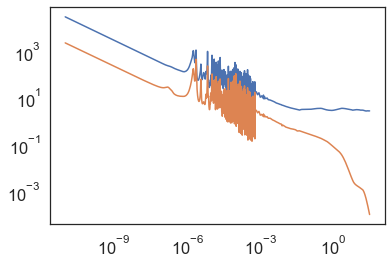

In [15]:
plt.loglog(energies, mt3)
plt.loglog(energies, mt101)

In [21]:
# for_ml = pd.DataFrame({"Energy": energies})
# for_ml.to_csv("U233_Energy.csv", index=False)

# Exploring Different Reaction Summations

In [22]:
import re

In [23]:
def sig_mt(MT, mt_array, lsig):
    mt_index = np.where(mt_array==MT)[0][0]
    if MT == mt_array[-1]:
        start_index = xs_table_pointer + lsig[mt_index] - 1
        end_index = jxs.iloc[0,7] - 1
        mt_data = xss[start_index: end_index]
    else:
        start_index = xs_table_pointer + lsig[mt_index] - 1
        end_index = xs_table_pointer + lsig[mt_index+1] - 1
        mt_data = xss[start_index: end_index]
    energy_index = int(mt_data[0])
    energy_points = int(mt_data[1])
    energy = xss[energy_index - 1 : energy_index + energy_points - 1]
    xs_data = mt_data[2:]
    print("{} Energy and {} Cross Section Points Avaliable.".format(len(energy), len(xs_data)))
    return xs_data, energy, start_index, end_index

In [17]:
# u233_ml = pd.read_csv("deprecated/U233_Data_ML.csv")
u233_ml = pd.read_csv("ml_xs_raw/k9_distance_manhattan_robust_one_hot_B0_v4/val.csv")

In [24]:
def fill_ml_xs(MT, ml_xs, ace_xs):
    ml_xs.loc[0:ml_xs[ml_xs[MT] == ml_xs[MT].values[0]].shape[0], MT] = ace_xs[
        0:ml_xs[ml_xs[MT] == ml_xs[MT].values[0]].shape[0]+1]
    ml_xs.iloc[-ml_xs[ml_xs[MT] == ml_xs[MT].values[-1]].shape[0]:, ml_xs.columns.get_loc(MT)] = ace_xs[
        -ml_xs[ml_xs[MT] == ml_xs[MT].values[-1]].shape[0] - 1:-1]
    return ml_xs

In [19]:
for i in list(u233_ml.columns)[1:]:
    if i == "Data_1":
        u233_ml = fill_ml_xs(i, u233_ml, mt1)
    elif i == "Data_2":
        u233_ml = fill_ml_xs(i, u233_ml, mt2)
    elif i == "Data_3":
        u233_ml = fill_ml_xs(i, u233_ml, sig_3)
    else:
        MT = re.sub("[^0-9]", "", i)
        sig, en, _, _ = sig_mt(int(MT), mt_array, lsig)
        u233_ml = fill_ml_xs(i, u233_ml, sig)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
u233_ml.head()

,Energy,MT_1,MT_102,MT_18,MT_2,MT_3,MT_4,MT_51
0,0.000010,34871.862492,2662.956927,5307.479448,35289.959992,35289.959992,35289.959992,35289.959992
1,0.000011,32515.959712,2625.513630,5245.260204,32214.642471,32214.642471,32214.642471,32214.642471
2,0.000012,31477.203062,2554.026541,4164.587194,32084.444197,32084.444197,32084.444197,32084.444197
3,0.000014,29502.251013,2484.370608,4164.693487,29326.619873,29326.619873,29326.619873,29326.619873
4,0.000015,28670.906569,2459.127893,4164.794717,29227.239243,29227.239243,29227.239243,29227.239243


In [21]:
u233_ml.head()

,Energy,MT_1,MT_102,MT_18,MT_2,MT_3,MT_4,MT_51
0,0.000010,34871.862492,2662.956927,5307.479448,35289.959992,35289.959992,35289.959992,35289.959992
1,0.000011,32515.959712,2625.513630,5245.260204,32214.642471,32214.642471,32214.642471,32214.642471
2,0.000012,31477.203062,2554.026541,4164.587194,32084.444197,32084.444197,32084.444197,32084.444197
3,0.000014,29502.251013,2484.370608,4164.693487,29326.619873,29326.619873,29326.619873,29326.619873
4,0.000015,28670.906569,2459.127893,4164.794717,29227.239243,29227.239243,29227.239243,29227.239243


In [22]:
from sklearn.metrics import mean_absolute_error

# Fixing MT1

In [23]:
# u233_ml = fill_ml_xs("Data_1", u233_ml, mt1)

AttributeError: 'DataFrame' object has no attribute 'Data_1'

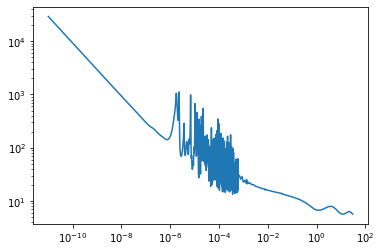

In [24]:
plt.loglog(energies, mt1)
plt.loglog(u233_ml.Energy, u233_ml.Data_1)

# Fixing MT18

In [25]:
sig_18, en_18, start_18, end_18 = sig_mt(18, mt_array, lsig)

8742 Energy and 8742 Cross Section Points Avaliable.


In [26]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_style('white')

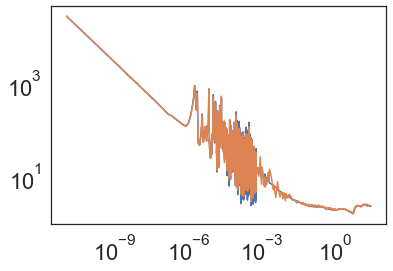

In [30]:
plt.loglog(en_18, sig_18)
plt.loglog(u233_ml.Energy, u233_ml.Data_18)

In [31]:
sig_18_ml = u233_ml.Data_18.values
diff_sig_18 = sig_18 - sig_18_ml
absolute_diff_sig_18 = np.absolute(diff_sig_18)

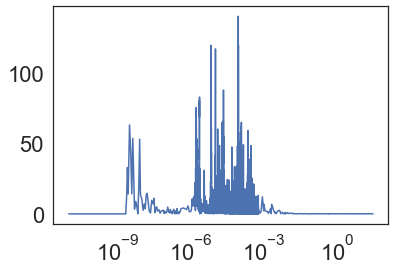

In [32]:
plt.plot(en_18, absolute_diff_sig_18)
plt.xscale('log')

In [33]:
# u233_ml[u233_ml.Data_18 == u233_ml.Data_18.values[0]].shape[0]

# u233_ml.Data_18.values[:u233_ml[u233_ml.Data_18 == u233_ml.Data_18.values[0]].shape[0]+5]

# u233_ml.loc[0:u233_ml[u233_ml.Data_18 == u233_ml.Data_18.values[0]].shape[0], "Data_18"] = sig_18[
#     0:u233_ml[u233_ml.Data_18 == u233_ml.Data_18.values[0]].shape[0]+1]

# Fixing MT102

In [28]:
sig_102, en_102, start_102, end_102 = sig_mt(102, mt_array, lsig)

8742 Energy and 8742 Cross Section Points Avaliable.


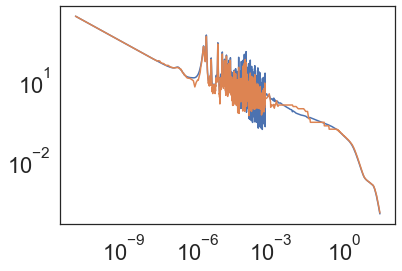

In [35]:
plt.loglog(en_102, sig_102)
plt.loglog(u233_ml.Energy, u233_ml.Data_102)

In [36]:
sig_102_ml = u233_ml.Data_102.values
diff_sig_102 = sig_102 - sig_102_ml
absolute_diff_sig_102 = np.absolute(diff_sig_102)

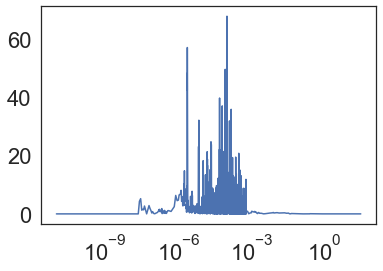

In [37]:
plt.plot(en_102, absolute_diff_sig_102)
plt.xscale('log')

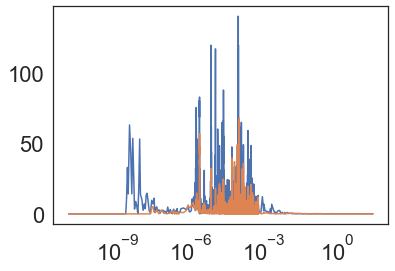

In [38]:
plt.plot(en_18, absolute_diff_sig_18)
plt.plot(en_102, absolute_diff_sig_102)
plt.xscale('log')

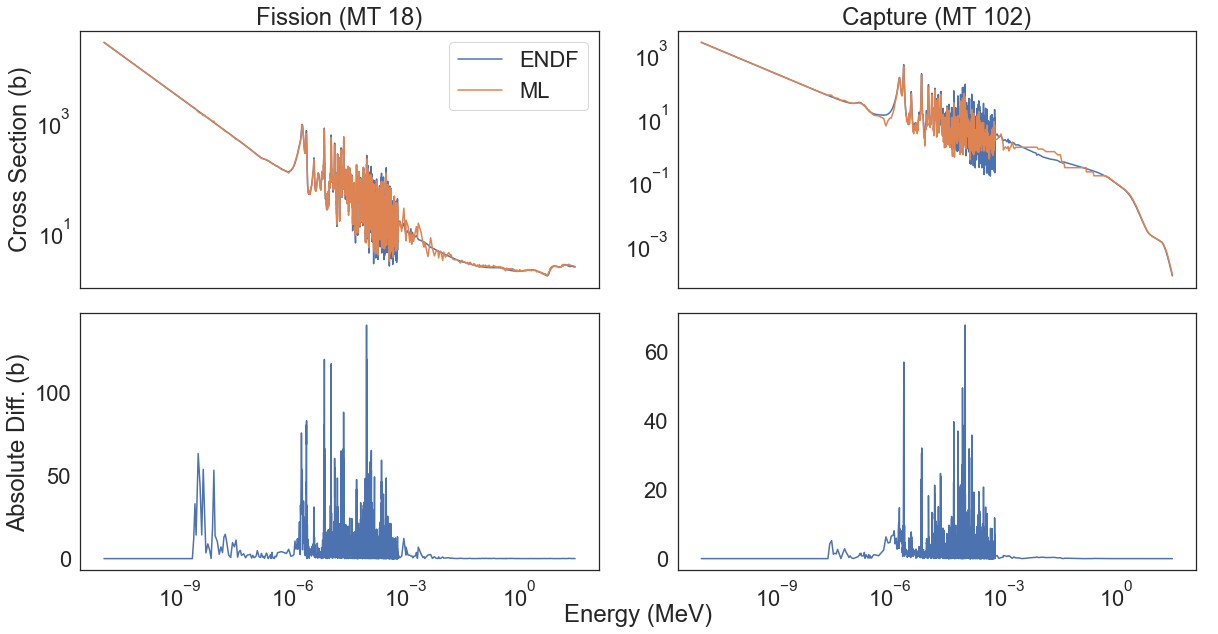

In [41]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(18,10))
axs[0, 0].loglog(en_18, sig_18, label="ENDF")
axs[0, 0].loglog(u233_ml.Energy, u233_ml.Data_18, label="ML")
axs[0, 0].legend()
axs[0, 0].set_title('Fission (MT 18)')

axs[0, 1].loglog(en_102, sig_102)
axs[0, 1].loglog(u233_ml.Energy, u233_ml.Data_102)
axs[0, 1].set_title('Capture (MT 102)')

axs[1, 0].plot(en_18, absolute_diff_sig_18)
axs[1, 0].set_xscale('log')

axs[1, 1].plot(en_102, absolute_diff_sig_102)
axs[1, 1].set_xscale('log')

axs[0,0].set(ylabel='Cross Section (b)')
axs[1,0].set(ylabel='Absolute Diff. (b)')


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy (MeV)")

plt.tight_layout()

plt.savefig("endf_ml_diff.png", dpi=600, bbox_inches="tight")

In [42]:
# u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[0]].shape[0]

# u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[-1]].shape[0]

# u233_ml.Data_102.values[:u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[0]].shape[0]]

# u233_ml.Data_102.values[-u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[-1]].shape[0]:-1]

# u233_ml.loc[0:u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[0]].shape[0], "Data_102"] = sig_102[
#     0:u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[0]].shape[0]+1]

# u233_ml.iloc[-u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[-1]].shape[0]:, 2] = sig_102[
#     -u233_ml[u233_ml.Data_102 == u233_ml.Data_102.values[-1]].shape[0] - 1:-1]

# Fixing MT3

In [43]:
Energy_Grid = pd.DataFrame({"Energy": energies})
Energy_Grid = Energy_Grid.set_index("Energy")

for i in mt_array:
    xs, en, _, _ = sig_mt(i, mt_array, lsig)
    to_add = pd.DataFrame({"Energy": en, "Data_" + str(int(i)): xs})
    to_add = to_add.set_index("Energy")
    Energy_Grid = pd.merge(Energy_Grid, to_add, left_index=True, right_index=True, how="outer")

139 Energy and 139 Cross Section Points Avaliable.
63 Energy and 63 Cross Section Points Avaliable.
8742 Energy and 8742 Cross Section Points Avaliable.
26 Energy and 26 Cross Section Points Avaliable.
364 Energy and 364 Cross Section Points Avaliable.
340 Energy and 340 Cross Section Points Avaliable.
329 Energy and 329 Cross Section Points Avaliable.
321 Energy and 321 Cross Section Points Avaliable.
315 Energy and 315 Cross Section Points Avaliable.
305 Energy and 305 Cross Section Points Avaliable.
301 Energy and 301 Cross Section Points Avaliable.
299 Energy and 299 Cross Section Points Avaliable.
296 Energy and 296 Cross Section Points Avaliable.
292 Energy and 292 Cross Section Points Avaliable.
289 Energy and 289 Cross Section Points Avaliable.
284 Energy and 284 Cross Section Points Avaliable.
281 Energy and 281 Cross Section Points Avaliable.
278 Energy and 278 Cross Section Points Avaliable.
275 Energy and 275 Cross Section Points Avaliable.
273 Energy and 273 Cross Section 

In [44]:
Energy_Grid = Energy_Grid.fillna(value=0)

In [45]:
Energy_Grid["Data_18"] = u233_ml.Data_18.values
Energy_Grid["Data_102"] = u233_ml.Data_102.values

In [46]:
# Energy_Grid["Data_3"] = Energy_Grid.sum(axis=1)

In [47]:
np.linspace(102,117,117-102+1).astype(int)

array([102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117])

In [48]:
def make_MT(rx_grid, MT):
    df = pd.DataFrame(index=rx_grid.index)
    df[MT] = 0
    if MT == "Data_3":
        for i in [4, 5, 11, 16, 17, 18, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 
                  41, 42, 44, 45, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]:
            if i in mt_array:
                df[MT] = df[MT].values + rx_grid["Data_" + str(i)].values
        return df
    elif MT == "Data_101":
        for i in np.linspace(102,117,117-102+1).astype(int):
            if i in mt_array:
                df[MT] = df[MT].values + rx_grid["Data_" + str(i)].values
        return df

In [49]:
Energy_Grid["Data_3"] = make_MT(Energy_Grid, "Data_3")

In [50]:
Energy_Grid["Data_101"] = make_MT(Energy_Grid, "Data_101")

In [51]:
Energy_Grid["Data_1"] = u233_ml["Data_1"].values

In [52]:
Energy_Grid

,Data_16,Data_17,Data_18,Data_37,Data_51,Data_52,Data_53,Data_54,Data_55,Data_56,Data_57,Data_58,Data_59,Data_60,Data_61,Data_62,Data_63,Data_64,Data_65,Data_66,Data_67,Data_68,Data_69,Data_70,Data_71,Data_72,Data_73,Data_74,Data_75,Data_76,Data_77,Data_78,Data_79,Data_80,Data_81,Data_82,Data_83,Data_84,Data_85,Data_86,Data_87,Data_88,Data_91,Data_102,Data_4,Data_3,Data_101,Data_1
Energy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.000000e-11,0.000000,0.000000,26877.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2232.315000,0.000000,29109.835000,2232.315000,29157.207400
1.125000e-11,0.000000,0.000000,25340.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2104.648000,0.000000,27445.008000,2104.648000,27489.828900
1.250000e-11,0.000000,0.000000,24039.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.647000,0.000000,26036.617000,1996.647000,26079.287200
1.375000e-11,0.000000,0.000000,22921.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1903.729000,0.000000,24824.939000,1903.729000,24865.765600
1.500000e-11,0.000000,0.000000,21945.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1822.684000,0.000000,23768.074000,1822.684000,23807.298300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.800000e+01,0.056734,0.045851,2.296800,0.149627,0.089681,0.039340,0.009014,0.000025,0.004165,0.000036,0.000007,0.001449,0.000013,0.000016,0.000020,0.000024,0.000011,0.000008,0.000659,0.000012,0.000024,0.000041,0.000032,0.000014,0.000013,0.000021,0.000029,0.000019,0.00001,0.000020,0.000028,0.000018,0.000021,0.000022,0.000021,0.000046,0.000031,0.024502,0.001733,0.010878,0.010814,0.001975,0.062356,0.000155,0.257150,2.806318,0.000155,5.928545
2.850000e+01,0.055079,0.041571,2.296800,0.163561,0.089224,0.039059,0.008865,0.000024,0.004089,0.000036,0.000007,0.001415,0.000012,0.000016,0.000020,0.000023,0.000011,0.000008,0.000639,0.000012,0.000024,0.000041,0.000032,0.000014,0.000013,0.000020,0.000029,0.000019,0.00001,0.000019,0.000027,0.000018,0.000020,0.000021,0.000021,0.000045,0.000030,0.024305,0.001711,0.010791,0.010729,0.001960,0.061695,0.000141,0.255056,2.812208,0.000141,5.881533
2.900000e+01,0.053518,0.037741,2.280800,0.176420,0.088789,0.038800,0.008731,0.000024,0.004018,0.000035,0.000007,0.001381,0.000012,0.000016,0.000019,0.000023,0.000011,0

# Fix MT2

In [53]:
def good_ace(path_to_ace, path_to_ml, ZZAAA, temp):
    to_skip, lines = get_to_skip_lines(path_to_ace, "92233", "03c")
    nsx, jxs, xss = read_nsx_jxs_xss(path_to_ace, to_skip, lines)
    nes, ntr, energy_pointer, mt_array_pointer, xs_pointers, xs_table_pointer, mt_18_pointer = get_pointers(nsx, jxs)
    energies, mt_array, lsig = get_energies_mt_array_lsig(xss, energy_pointer, nes, mt_array_pointer, ntr, xs_pointers)
    mt1, mt101, mt2 = get_mt1_mt101_mt2(xss, nes)
    mt3 = mt1 - mt2
    
    ml_df = pd.read_csv(path_to_ml)
    
    for i in list(ml_df.columns)[1:]:
        if i == "Data_1":
            ml_df = fill_ml_xs(i, ml_df, mt1)
        elif i == "Data_2":
            ml_df = fill_ml_xs(i, ml_df, mt2)
        elif i == "Data_3":
            ml_df = fill_ml_xs(i, ml_df, mt3)
        else:
            MT = re.sub("[^0-9]", "", i)
            sig, en, _, _ = sig_mt(int(MT), mt_array, lsig)
            ml_df = fill_ml_xs(i, ml_df, sig)
        
        
    sig_18, en_18, start_18, end_18 = sig_mt(18, mt_array, lsig, xs_table_pointer, jsx, xss)
    sig_102, en_102, start_102, end_102 = sig_mt(102, mt_array, lsig, xs_table_pointer, jsx, xss)
    
    Energy_Grid = pd.DataFrame({"Energy": energies})
    Energy_Grid = Energy_Grid.set_index("Energy")

    for i in mt_array:
        xs, en, _, _ = sig_mt(i, mt_array, lsig)
        to_add = pd.DataFrame({"Energy": en, "Data_" + str(int(i)): xs})
        to_add = to_add.set_index("Energy")
        Energy_Grid = pd.merge(Energy_Grid, to_add, left_index=True, right_index=True, how="outer")
        
    Energy_Grid = Energy_Grid.fillna(value=0)
    
    Energy_Grid["Data_18"]  = u233_ml.Data_18.values
    Energy_Grid["Data_102"] = u233_ml.Data_102.values
    
    Energy_Grid["Data_3"]   = make_MT(Energy_Grid, "Data_3")
    Energy_Grid["Data_101"] = make_MT(Energy_Grid, "Data_101")
    Energy_Grid["Data_1"]   = ml_df["Data_1"].values

- Replace negatives with nan interpolate

In [54]:
adjusting_mt1 = pd.DataFrame({"Data_1":Energy_Grid.Data_1.values, "Data_3":Energy_Grid.Data_3.values})
adjusting_mt1["Data_2"] = adjusting_mt1.Data_1.values - adjusting_mt1.Data_3.values

In [55]:
neg_ix = adjusting_mt1[adjusting_mt1.Data_2 < 0].index.tolist()

In [56]:
adjusting_mt1["Data_2"] = adjusting_mt1["Data_2"].apply(lambda x: x if x > 0 else -1)

In [57]:
adjusting_mt1 = adjusting_mt1.replace(to_replace=-1, value=np.nan)

In [58]:
adjusting_mt1 = adjusting_mt1.interpolate()

In [59]:
adjusting_mt1["Data_1_int"] = adjusting_mt1["Data_2"] + adjusting_mt1["Data_3"]

In [60]:
adjusting_mt1["Data_1_to_add"] = adjusting_mt1["Data_1_int"] - adjusting_mt1["Data_1"]

In [61]:
adjusting_mt1["Data_1_Final"] = adjusting_mt1["Data_1"] + adjusting_mt1["Data_1_to_add"]

In [62]:
adjusting_mt1.head()

,Data_1,Data_3,Data_2,Data_1_int,Data_1_to_add,Data_1_Final
0,29157.2074,29109.835,47.3724,29157.2074,0.0,29157.2074
1,27489.8289,27445.008,44.8209,27489.8289,0.0,27489.8289
2,26079.2872,26036.617,42.6702,26079.2872,0.0,26079.2872
3,24865.7656,24824.939,40.8266,24865.7656,0.0,24865.7656
4,23807.2983,23768.074,39.2243,23807.2983,0.0,23807.2983


In [63]:
adjusting_mt1.iloc[neg_ix]

,Data_1,Data_3,Data_2,Data_1_int,Data_1_to_add,Data_1_Final
51,2386.0400,2482.06750,11.206465,2493.273965,107.233965,2493.273965
58,1640.5600,1850.84030,314.858900,2165.699200,525.139200,2165.699200
62,1419.6800,1463.80380,271.545100,1735.348900,315.668900,1735.348900
64,1250.5800,1378.92970,22.829482,1401.759182,151.179182,1401.759182
65,1242.8800,1304.39520,19.697564,1324.092764,81.212764,1324.092764
...,...,...,...,...,...,...
8250,30.2942,34.41278,2.201923,36.614703,6.320503,36.614703
8251,28.3446,33.86298,2.170757,36.033737,7.689137,36.033737
8252,26.7518,32.47478,2.139591,34.614371,7.862571,34.614371
8253,26.7518,28.21312,2.108426,30.321546,3.569746,30.321546


In [64]:
Energy_Grid["Data_1"] = adjusting_mt1["Data_1_Final"].values
Energy_Grid["Data_2"] = adjusting_mt1["Data_2"].values

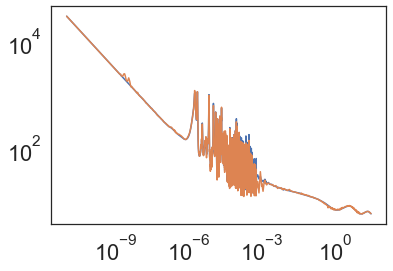

In [65]:
plt.loglog(energies, mt1)
plt.loglog(energies, Energy_Grid.Data_1)

Text(0, 0.5, 'Cross Section (b)')

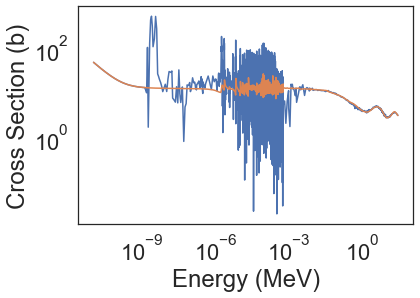

In [66]:
plt.loglog(energies, Energy_Grid.Data_2)
plt.loglog(energies, mt2)
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross Section (b)")

In [26]:
sig_18, en_18, _, _ = sig_mt(18, mt_array, lsig)

8742 Energy and 8742 Cross Section Points Avaliable.


In [30]:
diff_18 = np.abs(Energy_Grid.MT_18 - sig_18)
diff_102 = np.abs(Energy_Grid.MT_102 - sig_102)
diff_1 = np.abs(Energy_Grid.MT_1 - mt1)

In [57]:
# %matplotlib qt
# import matplotlib.pyplot as plt

In [16]:
import seaborn as sns

sns.set(font_scale=1.5, style="white")

In [17]:
Energy_Grid = pd.read_csv("ml_xs_raw/k9_distance_manhattan_robust_one_hot_B0_v4/val.csv")

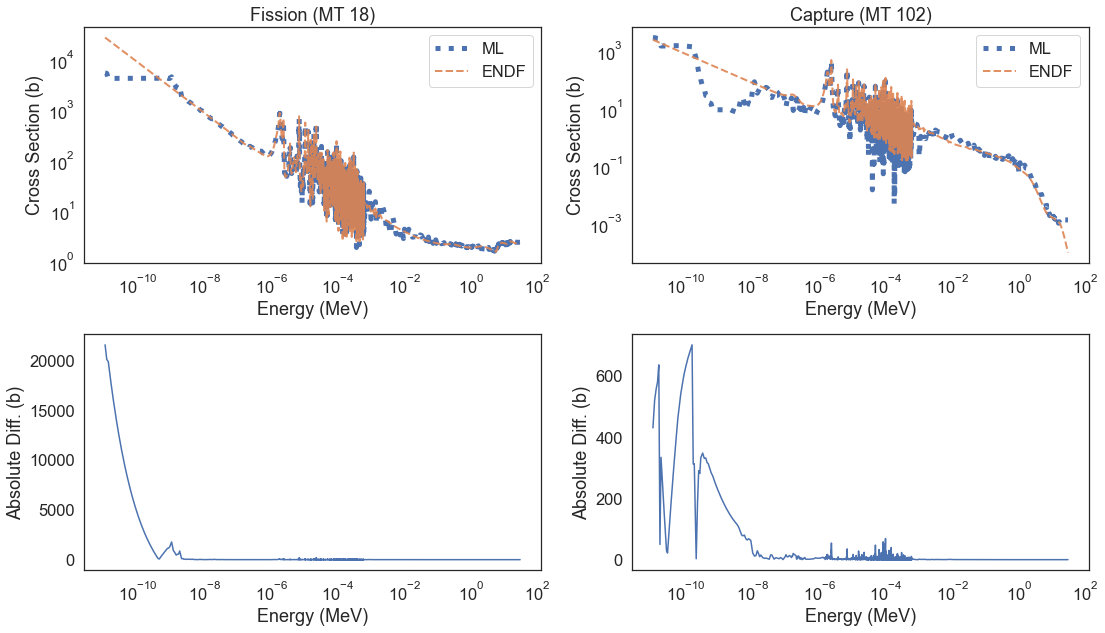

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(18,10))
# fig.suptitle('ENDF vs ML Cross Sections for U-233')
fig.subplots_adjust(hspace=.3)

axs[0, 0].loglog(energies, Energy_Grid.MT_18, linestyle="dotted", linewidth=5, label="ML")
axs[0, 0].loglog(energies, sig_18, linestyle="dashed", linewidth=2, label="ENDF", alpha=0.9)
axs[0, 0].set_title("Fission (MT 18)")
axs[0, 0].legend()

axs[0, 1].loglog(energies, Energy_Grid.MT_102, linestyle="dotted", linewidth=5, label="ML")
axs[0, 1].loglog(energies, sig_102, linestyle="dashed", linewidth=2, label="ENDF", alpha=0.9)
axs[0, 1].set_title("Capture (MT 102)")
axs[0, 1].legend()

axs[1, 0].plot(energies, diff_18)
axs[1, 0].set_xscale('log')

axs[1, 1].plot(energies, diff_102)
axs[1, 1].set_xscale('log')

# axs[0,0].set(ylabel='Cross Section (b)')
# axs[0,1].set(ylabel='Cross Section (b)')
# axs[1,0].set(ylabel='Absolute Diff. (b)', xlabel="Energy (MeV)")
# axs[1,1].set(ylabel='Absolute Diff. (b)', xlabel="Energy (MeV)")
axs[0,0].set(ylabel='Cross Section (b)', xlabel="Energy (MeV)")
axs[0,1].set(ylabel='Cross Section (b)', xlabel="Energy (MeV)")
axs[1,0].set(ylabel='Absolute Diff. (b)', xlabel="Energy (MeV)")
axs[1,1].set(ylabel='Absolute Diff. (b)', xlabel="Energy (MeV)")

# fig.text(0.5, 0.04, 'Energy (MeV)', ha='center')
# fig.text(0.04, 0.5, 'Cross Section (b)', va='center', rotation='vertical')
plt.savefig("mt18_mt102_u233.png", bbox_inches='tight', dpi=600)

In [32]:
# fig, axs = plt.subplots(2, 2, figsize=(18,10))
# # fig.suptitle('ENDF vs ML Cross Sections for U-233')

# axs[0, 0].loglog(energies, Energy_Grid.Data_18, linestyle="dotted", linewidth=5, label="ML")
# axs[0, 0].loglog(energies, sig_18, linestyle="dashed", linewidth=2, label="ENDF")
# axs[0, 0].set_title("Fission (MT 18)")
# axs[0, 0].legend()

# axs[0, 1].loglog(energies, Energy_Grid.Data_102, linestyle="dotted", linewidth=5, label="ML")
# axs[0, 1].loglog(energies, sig_102, linestyle="dashed", linewidth=2, label="ENDF")
# axs[0, 1].set_title("Capture (MT 102)")
# axs[0, 1].legend()

# axs[1, 0].plot(energies, diff_18, label="Abs. Diff.")
# axs[1, 0].set_xscale('log')
# axs[1, 0].legend()

# axs[1, 1].plot(energies, diff_102, label="Abs. Diff.")
# axs[1, 1].set_xscale('log')
# axs[1, 1].legend()

# fig.text(0.5, 0.04, 'Energy (MeV)', ha='center')
# fig.text(0.04, 0.5, 'Cross Section (b)', va='center', rotation='vertical')

In [33]:
sns.set(font_scale=2.5, style="white")

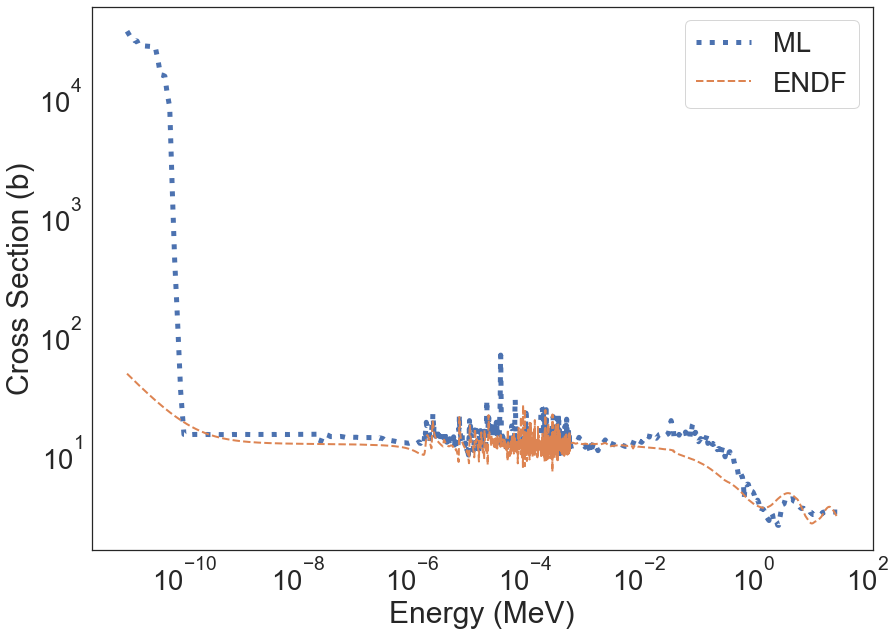

In [34]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.MT_2, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(energies, mt2, linestyle="dashed", linewidth=2, label="ENDF")
plt.legend()
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross Section (b)")
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.savefig("mt2_u233.png", bbox_inches='tight', dpi=600)

In [69]:
sig_4, en_4, _, _ = sig_mt(4, mt_array, lsig)

364 Energy and 364 Cross Section Points Avaliable.


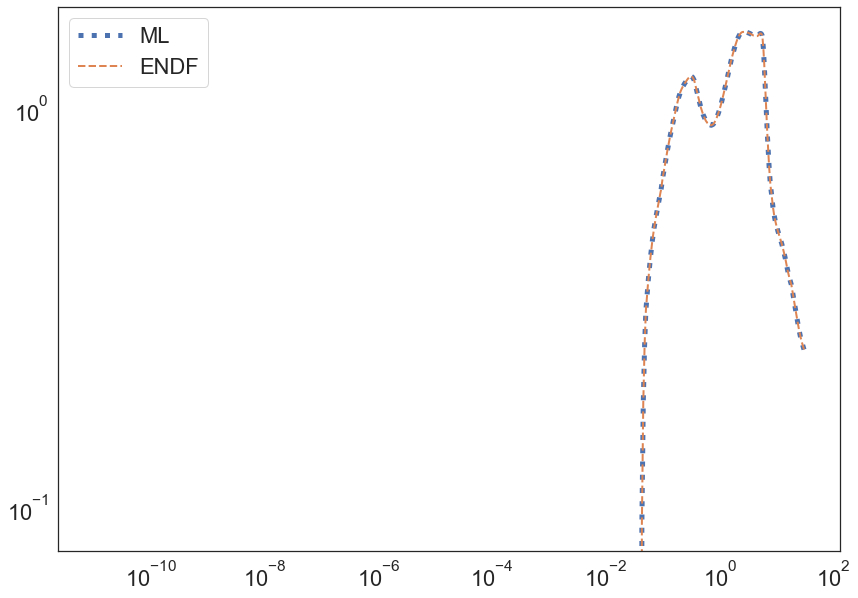

In [72]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.Data_4, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(en_4, sig_4, linestyle="dashed", linewidth=2, label="ENDF")
plt.legend()

In [ ]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.Data_18, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(energies, sig_18, linestyle="dashed", linewidth=2, label="ENDF")
plt.legend()

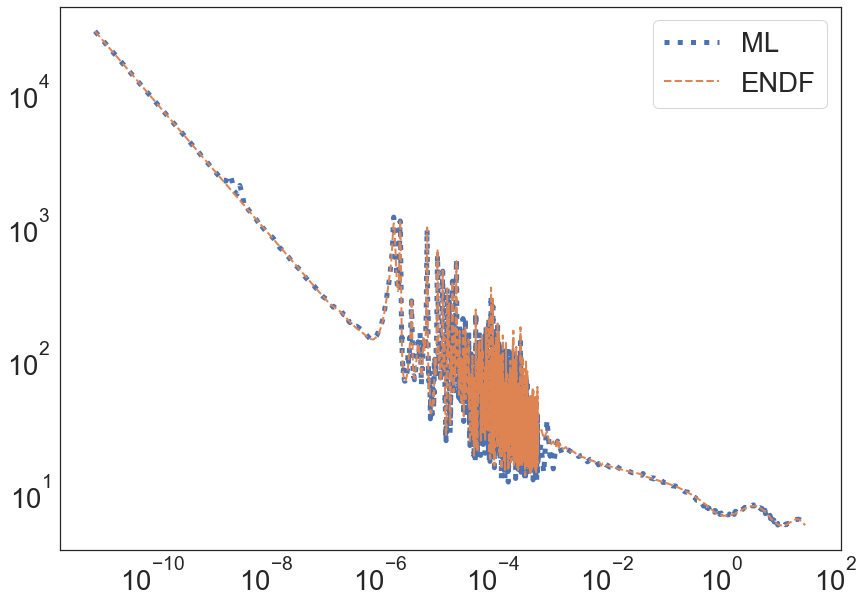

In [107]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.Data_1, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(energies, mt1, linestyle="dashed", linewidth=2, label="ENDF")
plt.legend()

In [667]:
sig_102, en_102, _, _ = sig_mt(102, mt_array, lsig)

8742 Energy and 8742 Cross Section Points Avaliable.


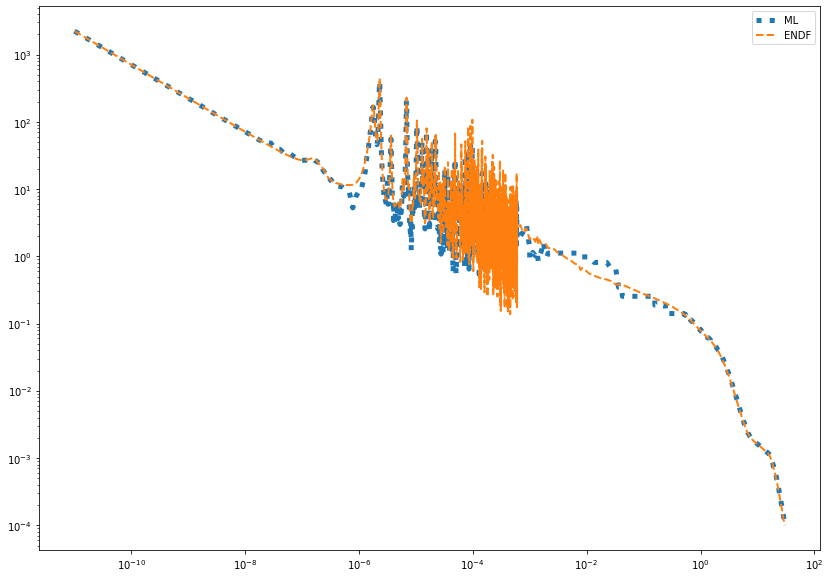

In [668]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.Data_102, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(energies, sig_102, linestyle="dashed", linewidth=2, label="ENDF")
plt.legend()

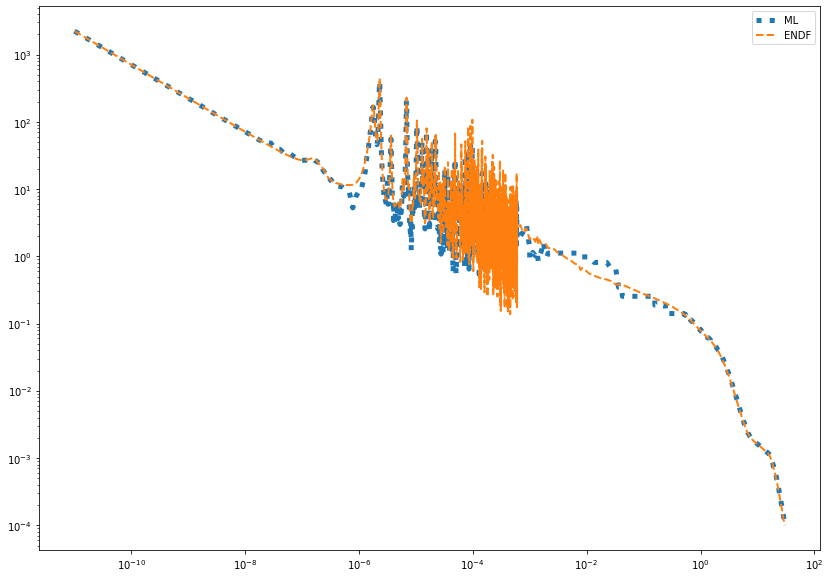

In [670]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.Data_101, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(energies, mt101, linestyle="dashed", linewidth=2, label="ENDF")
plt.legend()

In [689]:
%matplotlib qt
import matplotlib.pyplot as plt

In [719]:
import seaborn as sns

In [727]:
sns.set(font_scale=2)
sns.set_style("white")

In [732]:
import importlib
importlib.reload(plt)
importlib.reload(sns)

<module 'seaborn' from 'C:\\Users\\Pedro\\Anaconda3\\envs\\data_mining_gpu\\lib\\site-packages\\seaborn\\__init__.py'>

In [734]:
Energy_Grid.to_csv("ML_GRID.csv", index=False)

In [735]:
Energy_Grid

,Data_16,Data_17,Data_18,Data_37,Data_51,Data_52,Data_53,Data_54,Data_55,Data_56,Data_57,Data_58,Data_59,Data_60,Data_61,Data_62,Data_63,Data_64,Data_65,Data_66,Data_67,Data_68,Data_69,Data_70,Data_71,Data_72,Data_73,Data_74,Data_75,Data_76,Data_77,Data_78,Data_79,Data_80,Data_81,Data_82,Data_83,Data_84,Data_85,Data_86,Data_87,Data_88,Data_91,Data_102,Data_4,Data_3,Data_101,Data_1,Data_2
Energy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.000000e-11,0.000000,0.000000,26877.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2232.315000,0.000000,29109.835000,2232.315000,29157.207400,47.372400
1.125000e-11,0.000000,0.000000,25340.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2104.648000,0.000000,27445.008000,2104.648000,27489.828900,44.820900
1.250000e-11,0.000000,0.000000,24039.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.647000,0.000000,26036.617000,1996.647000,26079.287200,42.670200
1.375000e-11,0.000000,0.000000,22921.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1903.729000,0.000000,24824.939000,1903.729000,24865.765600,40.826600
1.500000e-11,0.000000,0.000000,21945.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1822.684000,0.000000,23768.074000,1822.684000,23807.298300,39.224300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.800000e+01,0.056734,0.045851,2.296800,0.149627,0.089681,0.039340,0.009014,0.000025,0.004165,0.000036,0.000007,0.001449,0.000013,0.000016,0.000020,0.000024,0.000011,0.000008,0.000659,0.000012,0.000024,0.000041,0.000032,0.000014,0.000013,0.000021,0.000029,0.000019,0.00001,0.000020,0.000028,0.000018,0.000021,0.000022,0.000021,0.000046,0.000031,0.024502,0.001733,0.010878,0.010814,0.001975,0.062356,0.000155,0.257150,2.806318,0.000155,5.928545,3.122227
2.850000e+01,0.055079,0.041571,2.296800,0.163561,0.089224,0.039059,0.008865,0.000024,0.004089,0.000036,0.000007,0.001415,0.000012,0.000016,0.000020,0.000023,0.000011,0.000008,0.000639,0.000012,0.000024,0.000041,0.000032,0.000014,0.000013,0.000020,0.000029,0.000019,0.00001,0.000019,0.000027,0.000018,0.000020,0.000021,0.000021,0.000045,0.000030,0.024305,0.001711,0.010791,0.010729,0.001960,0.061695,0.000141,0.255056,2.812208,0.000141,5.881533,3.069325
2.900000e+01,0.053518,0.037741,2.280800,0.176420,0.088789,0.038800,0.008731,0.000024,0.

In [733]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
# fig.suptitle('ENDF vs ML Cross Sections for U-233')

axs[0, 0].loglog(energies, Energy_Grid.Data_18, linestyle="dotted", linewidth=5, label="ML")
axs[0, 0].loglog(energies, sig_18, linestyle="dashed", linewidth=2, label="ENDF")
axs[0, 0].set_title("MT 18")
axs[0, 0].legend()

axs[0, 1].loglog(energies, Energy_Grid.Data_1, linestyle="dotted", linewidth=5, label="ML")
axs[0, 1].loglog(energies, mt1, linestyle="dashed", linewidth=2, label="ENDF")
axs[0, 1].set_title("MT 1")
axs[0, 1].legend()

axs[0, 2].loglog(energies, Energy_Grid.Data_102, linestyle="dotted", linewidth=5, label="ML")
axs[0, 2].loglog(energies, sig_102, linestyle="dashed", linewidth=2, label="ENDF")
axs[0, 2].set_title("MT 102")
axs[0, 2].legend()

axs[1, 0].loglog(energies, Energy_Grid.Data_101, linestyle="dotted", linewidth=5, label="ML")
axs[1, 0].loglog(energies, mt101, linestyle="dashed", linewidth=2, label="ENDF")
axs[1, 0].set_title("MT 101")
axs[1, 0].legend()

axs[1, 1].loglog(energies, Energy_Grid.Data_2, linestyle="dotted", linewidth=5, label="ML")
axs[1, 1].loglog(energies, mt2, linestyle="dashed", linewidth=2, label="ENDF")
axs[1, 1].set_title("MT 2")
axs[1, 1].legend()

axs[1, 2].loglog(energies, Energy_Grid.Data_3, linestyle="dotted", linewidth=5, label="ML")
axs[1, 2].loglog(energies, mt3, linestyle="dashed", linewidth=2, label="ENDF")
axs[1, 2].set_title("MT 3")
axs[1, 2].legend()


# axs[0, 0].annotate('A', xy=get_axis_limits(axs[0, 0]))
# axs[0, 1].annotate('B', xy=get_axis_limits(axs[0, 1]))
# axs[0, 2].annotate('C', xy=get_axis_limits(axs[0, 2]))
# axs[1, 0].annotate('D', xy=get_axis_limits(axs[1, 0]))
# axs[1, 1].annotate('E', xy=get_axis_limits(axs[1, 1]))
# axs[1, 2].annotate('F', xy=get_axis_limits(axs[1, 2]))
                   
# axs[0, 0].annotate('A')
# axs[0, 1].annotate('B')
# axs[0, 2].annotate('C')
# axs[1, 0].annotate('D')
# axs[1, 1].annotate('E')
# axs[1, 2].annotate('F')


fig.text(0.5, 0.04, 'Energy (MeV)', ha='center')
fig.text(0.04, 0.5, 'Cross Section (mb)', va='center', rotation='vertical')


# for ax in axs.flat:
#     ax.set(xlabel='Energy (MeV)', ylabel='Cross Section (mb)')

Text(0.04, 0.5, 'Cross Section (mb)')

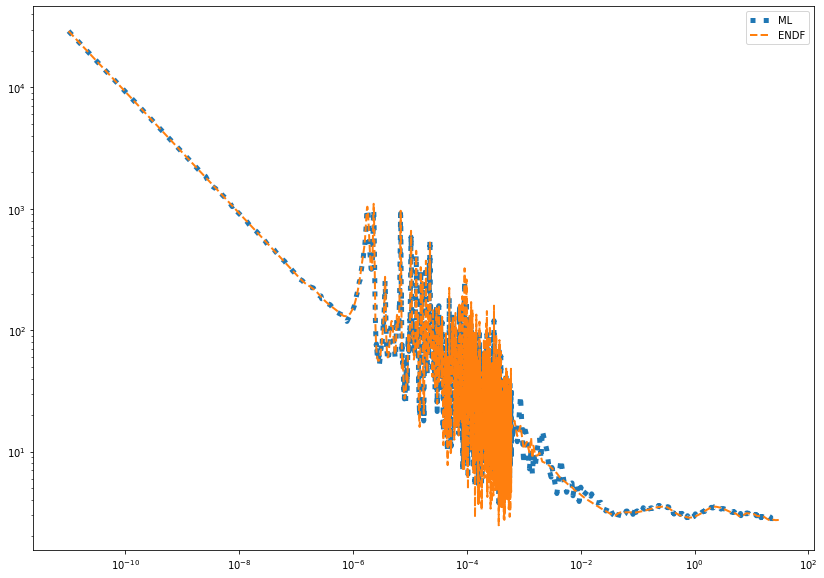

In [672]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.Data_3, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(energies, mt3, linestyle="dashed", linewidth=2, label="ENDF")
plt.legend()

In [615]:
Energy_Grid

,Data_16,Data_17,Data_18,Data_37,Data_51,Data_52,Data_53,Data_54,Data_55,Data_56,Data_57,Data_58,Data_59,Data_60,Data_61,Data_62,Data_63,Data_64,Data_65,Data_66,Data_67,Data_68,Data_69,Data_70,Data_71,Data_72,Data_73,Data_74,Data_75,Data_76,Data_77,Data_78,Data_79,Data_80,Data_81,Data_82,Data_83,Data_84,Data_85,Data_86,Data_87,Data_88,Data_91,Data_102,Data_4,Data_3,Data_101,Data_1,Data_2
Energy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.000000e-11,0.000000,0.000000,26877.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2232.315000,0.000000,29109.835000,2232.315000,29157.207400,47.372400
1.125000e-11,0.000000,0.000000,25340.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2104.648000,0.000000,27445.008000,2104.648000,27489.828900,44.820900
1.250000e-11,0.000000,0.000000,24039.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.647000,0.000000,26036.617000,1996.647000,26079.287200,42.670200
1.375000e-11,0.000000,0.000000,22921.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1903.729000,0.000000,24824.939000,1903.729000,24865.765600,40.826600
1.500000e-11,0.000000,0.000000,21945.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1822.684000,0.000000,23768.074000,1822.684000,23807.298300,39.224300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.800000e+01,0.056734,0.045851,2.296800,0.149627,0.089681,0.039340,0.009014,0.000025,0.004165,0.000036,0.000007,0.001449,0.000013,0.000016,0.000020,0.000024,0.000011,0.000008,0.000659,0.000012,0.000024,0.000041,0.000032,0.000014,0.000013,0.000021,0.000029,0.000019,0.00001,0.000020,0.000028,0.000018,0.000021,0.000022,0.000021,0.000046,0.000031,0.024502,0.001733,0.010878,0.010814,0.001975,0.062356,0.000155,0.257150,2.806318,0.000155,5.928545,3.122227
2.850000e+01,0.055079,0.041571,2.296800,0.163561,0.089224,0.039059,0.008865,0.000024,0.004089,0.000036,0.000007,0.001415,0.000012,0.000016,0.000020,0.000023,0.000011,0.000008,0.000639,0.000012,0.000024,0.000041,0.000032,0.000014,0.000013,0.000020,0.000029,0.000019,0.00001,0.000019,0.000027,0.000018,0.000020,0.000021,0.000021,0.000045,0.000030,0.024305,0.001711,0.010791,0.010729,0.001960,0.061695,0.000141,0.255056,2.812208,0.000141,5.881533,3.069325
2.900000e+01,0.053518,0.037741,2.280800,0.176420,0.088789,0.038800,0.008731,0.000024,0.

In [325]:
# def subsitute_mt3(x):
#     if x[0] < x[1]:
#         return x[0], x[0]
#     else:
#         return x[0], x[1]
    
# u233_ml[["Data_1", "Data_3"]] = u233_ml[["Data_1", "Data_3"]].apply(subsitute_mt3, axis=1, result_type="expand")

# Adjusting MT102

We are calculating MT3 based on MT102 so we dont have to adjust MT102 now (we are throwing away ML on MT3)

In [326]:
# u233_ml[u233_ml.Data_102 > u233_ml.Data_3]

# def subsitute_mt102(x):
#     if x[0] < x[1]:
#         return x[0], x[0]
#     else:
#         return x[0], x[1]
    
# u233_ml[["Data_3", "Data_102"]] = u233_ml[["Data_3", "Data_102"]].apply(subsitute_mt102, axis=1, result_type="expand")

# Implementing changes to XSS

We changed:
- MT1
- MT2
- MT101
- MT102
- MT18

In [328]:
def changing_xss(MT, xss, xs_grid):
    if MT == 1:
        xss[nes:nes*2] = xs_grid["Data_" + str(i)].values
        return xss
    elif MT == 2:
        xss[nes*3:nes*4] = xs_grid["Data_" + str(i)].values
        return xss
    elif MT == 101:
        xss[nes*2:nes*3] = xs_grid["Data_" + str(i)].values
        return xss
    else:
        _, _, start, end = sig_mt(MT, mt_array, lsig)
        # We sum up 2 since the first are just energy pointers
        xss[start + 2 : end] = xs_grid["Data_" + str(i)].values
        return xss

In [329]:
for i in [1, 2, 101, 102, 18]:
    xss = changing_xss(i, xss, Energy_Grid)

8742 Energy and 8742 Cross Section Points Avaliable.
8742 Energy and 8742 Cross Section Points Avaliable.


In [330]:
if (len(xss)/4 - len(xss)//4)/0.25 == 0:
    print("It is wokring")
elif 4 - (len(xss)/4 - len(xss)//4)/0.25 == 3:
    xss = np.append(xss, (np.nan, np.nan, np.nan))
elif 4 - (len(xss)/4 - len(xss)//4)/0.25 == 2:
    xss = np.append(xss, (np.nan, np.nan))
elif 4 - (len(xss)/4 - len(xss)//4)/0.25 == 1:
    xss = np.append(xss, (np.nan))

In [331]:
xss

array([1.000e-11, 1.125e-11, 1.250e-11, ...,       nan,       nan,
             nan])

# Visualizaing MT2 to confirm changes

In [332]:
mt1, mt101, mt2 = get_mt1_mt101_mt2(xss, nes)

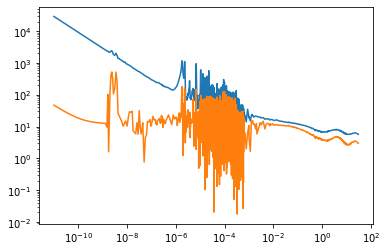

In [335]:
plt.loglog(energies, mt1)
plt.loglog(energies, mt2)

# Compiling new ACE file

In [526]:
import math

In [576]:
xss_reshaped = xss.reshape((-1,4))

In [598]:
to_write = pd.DataFrame(xss.reshape((-1,4)))
to_write.columns = ["column_1", "column_2", "column_3", "column_4"]

In [599]:
# to_write = to_write.loc[:6]
to_write = to_write.astype("object")
# to_write.iloc[0,0] = 0
# to_write.iloc[0,1] = to_write.iloc[0,1] * -1

In [600]:
to_write

,column_1,column_2,column_3,column_4
0,1e-11,1.125e-11,1.25e-11,1.375e-11
1,1.5e-11,1.625e-11,1.75e-11,2e-11
2,2.1875e-11,2.375e-11,2.5625e-11,2.75e-11
3,3.125e-11,3.5e-11,3.875e-11,4.25e-11
4,4.625e-11,5e-11,5.625e-11,6.25e-11
...,...,...,...,...
74355,0.977134,0.981989,0.985747,0.988695
74356,0.991033,0.992905,0.99441,0.995611
74357,0.997357,0.998468,0.999183,0.999641
74358,1,3,4,18


In [601]:
# def parsing_datatypes(x):
#     if math.isnan(x):
#         return ""
#     elif isinstance(x, int):
#         return "{:20}".format(x)
#     else:
#         return "{:20.11E}".format(x)
    
def parsing_datatypes(x):
    if math.isnan(x):
        return ""
    elif x - int(x) == 0:
        return "{:20}".format(int(x))
    else:
        return "{:20.11E}".format(x)

In [574]:
def parsing_datatypes_2(x):
    x[0] = parsing_datatypes(x[0])
    x[1] = parsing_datatypes(x[1])
    x[2] = parsing_datatypes(x[2])
    x[3] = parsing_datatypes(x[3])
    return x[0], x[1], x[2], x[3]
    
to_write[["column_1", "column_2", "column_3", "column_4"]] = to_write[["column_1", "column_2", "column_3", "column_4"]].apply(parsing_datatypes_2, axis=1, result_type="expand")

In [605]:
to_write = to_write.applymap(parsing_datatypes)

In [607]:
len(to_write.iloc[-1,:][0])

20

In [610]:
to_write.to_csv("NEWU233.txt", float_format="%.11E", sep="\t", index=False, header=False)
with open('NEWU233.txt') as fin, open('NEWU233_Final.txt', 'w') as fout:
    for line in fin:
        fout.write(line.replace('\t', ''))

In [608]:
to_write.to_csv("NEWU233.txt", float_format="{:20.18E}", sep="\t", index=False, header=False)

In [484]:
to_write.to_csv("NEWU233.txt", float_format="%.11E", sep="\t", index=False, header=False)

In [457]:
# decimal.Decimal(str(17.000)).as_tuple().exponent == -1

# def parsing_datatypes(x):
#     if decimal.Decimal(str(x)).as_tuple().exponent == -1:
#         x = int(x)
#         return x
#     else:
#         return x

In [458]:
def parsing_datatypes(x):
    if math.isnan(x):
        return x
    if x - int(x) == 0.0:
        return int(x)
    else:
        return x

In [459]:
to_write = to_write.applymap(parsing_datatypes)

In [460]:
to_write.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74360 entries, 0 to 74359
Data columns (total 4 columns):
column_1    74360 non-null float64
column_2    74359 non-null float64
column_3    74359 non-null float64
column_4    74359 non-null float64
dtypes: float64(4)
memory usage: 2.3 MB


In [461]:
to_write.loc[int(mt_array_pointer/4):int(mt_array_pointer/4)+20, :]

,column_1,column_2,column_3,column_4
10942,6.086589,16.0000,17.00000,18.00000
10943,37.000000,51.0000,52.00000,53.00000
10944,54.000000,55.0000,56.00000,57.00000
10945,58.000000,59.0000,60.00000,61.00000
10946,62.000000,63.0000,64.00000,65.00000
10947,66.000000,67.0000,68.00000,69.00000
10948,70.000000,71.0000,72.00000,73.00000
10949,74.000000,75.0000,76.00000,77.00000
10950,78.000000,79.0000,80.00000,81.00000
10951,82.000000,83.0000,84.00000,85.00000


In [467]:
to_write["column_0"] = ""

In [468]:
to_write = to_write[["column_0", "column_1", "column_2", "column_3", "column_4"]]

In [469]:
to_write.iloc[0,0]

''

In [470]:
# to_write.update(to_write.select_dtypes(include=np.number).applymap('{:,g}'.format))

In [471]:
to_write

,column_0,column_1,column_2,column_3,column_4
0,,1e-11,1.125e-11,1.25e-11,1.375e-11
1,,1.5e-11,1.625e-11,1.75e-11,2e-11
2,,2.1875e-11,2.375e-11,2.5625e-11,2.75e-11
3,,3.125e-11,3.5e-11,3.875e-11,4.25e-11
4,,4.625e-11,5e-11,5.625e-11,6.25e-11
...,...,...,...,...,...
74355,,0.977134,0.981989,0.985747,0.988695
74356,,0.991033,0.992905,0.99441,0.995611
74357,,0.997357,0.998468,0.999183,0.999641
74358,,1,3,4,18


In [472]:
to_write.iloc[0,3]

1.25e-11

In [473]:
to_write.to_csv("NEWU233.txt", float_format="%.11E", sep="\t", index=False, header=False)
with open('NEWU233.txt') as fin, open('NEWU233_Final.txt', 'w') as fout:
    for line in fin:
        fout.write(line.replace('\t', '   '))

In [342]:
mt_array

array([ 16.,  17.,  18.,  37.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  91., 102.,
         4.])

# SAVING WITH PADDING

In [573]:
nsx_string = nsx.copy()

In [574]:
nsx_string = nsx_string.astype(str)

In [575]:
for x in nsx_string.columns:
    nsx_string[x] = nsx_string[x].str.pad(9, side='left')

In [577]:
nsx_string.to_csv("testing_df.txt", sep='\t', index=False)

In [579]:
with open('testing_df.txt') as fin, open('testing_df_notab.txt', 'w') as fout:
    for line in fin:
        fout.write(line.replace('\t', ''))

# SAVING XSS

In [605]:
xss2 = pd.read_csv("./17035ENDF7.ace", delim_whitespace=True, skiprows=12, nrows=lines, header=None) # .values.flatten()
# xss2 = testing_xss[~np.isnan(testing_xss)]

In [635]:
xss2.to_csv("to_string.txt", float_format="%.11E", sep="\t", index=False, header=False)

In [636]:
# with open('testing_fortran.txt') as fin, open('testing_fortran_E.txt', 'w') as fout:
#     for line in fin:
#         fout.write(line.replace('e', 'E'))

# Testing Replacement

In [609]:
replacement = pd.read_csv("./17035ENDF7.ace", delim_whitespace=True, skiprows=12, nrows=lines, header=None)

In [633]:
replacement.head()

,0,1,2,3
0,1.000000e-11,1.125000e-11,1.250000e-11,1.375000e-11
1,1.500000e-11,1.625000e-11,1.750000e-11,2.000000e-11
2,2.187500e-11,2.375000e-11,2.562500e-11,2.750000e-11
3,3.125000e-11,5.000000e+00,3.875000e-11,4.250000e-11
4,4.615080e-11,4.625000e-11,4.648438e-11,4.671875e-11


In [629]:
replacement.iat[round(13/4), int((13/4 - round(13/4))/0.25)] = 5

In [634]:
replacement.head()

,0,1,2,3
0,1.000000e-11,1.125000e-11,1.250000e-11,1.375000e-11
1,1.500000e-11,1.625000e-11,1.750000e-11,2.000000e-11
2,2.187500e-11,2.375000e-11,2.562500e-11,2.750000e-11
3,3.125000e-11,5.000000e+00,3.875000e-11,4.250000e-11
4,4.615080e-11,4.625000e-11,4.648438e-11,4.671875e-11


# Automating

In [525]:
dataframes_chlorine_35 = {}
data_arrays_chlorine_35 = {}

ace = "./17035ENDF7.ace"
with open(ace, "r") as ace_file:
    nsx_dataframes = {}
    jxs_dataframes = {}
    xss_dataframes = {}
    points = []
    indexes = []
    for index, line in enumerate(ace_file):
        if line.startswith(" 17035."):
            points.append(line[1:10])
            indexes.append(index)
    for x in range(0, len(indexes) - 1):
        nsx = pd.read_csv(ace, delim_whitespace=True, skiprows=indexes[x]+6, nrows=2, header=None) # .values.flatten()
        jxs = pd.read_csv(ace, delim_whitespace=True, skiprows=indexes[x]+8, nrows=4, header=None)
        xss = pd.read_csv(ace, delim_whitespace=True, skiprows=indexes[x]+12, nrows=indexes[x+1]-indexes[x]-12, header=None).values.flatten()
        xss = testing_xss[~np.isnan(testing_xss)]
        nsx_dataframes[points[x]] = nsx
        jxs_dataframes[points[x]] = jxs
        xss_dataframes[points[x]] = xss

In [ ]:
# XSS
xss_length = int(np.ceil(nsx.iloc[0,0]/4))  # (1)
nes = nsx.iloc[0,2] # NES (3)
ntr = nsx.iloc[0,3] # NTR: Number of Reactions excluding elastic scattering MT2 (4)
nr = nsx.iloc[0,4] # NR: # of reactions having second. neutrons exlcuding elastic scattering (5)
ntrp = nsx.iloc[0,5] # NTRP: # of photon production reactions (6)

# JSX These are the indexes in the continuous array where stuff starts
energy_pointer = jxs.iloc[0,0] - 1           # ESZ (1)
fission_v_data = jxs.iloc[0,1] - 1           # NU (2)
mt_array_pointer = jxs.iloc[0,2] - 1         # MTR (3)
q_values_pointer = jxs.iloc[0,3] - 1         # LQR (4)
rx_type_array = jxs.iloc[0,4] - 1            # TYR (5)
xs_pointers = jxs.iloc[0,5] - 1              # LSIG (6)
xs_table_pointer = jxs.iloc[0,6] - 1         # SIG (7)
mt_18_pointer = (jxs.iloc[2,4] - 1).clip(0)  # FIS (21)

q_values_per_mt = xss[q_values_pointer:q_values_pointer+ntr]
frames = xss[rx_type_array:rx_type_array+ntr]

energies = xss[energy_pointer:energy_pointer+nes]
mt1 = xss[nes:nes*2]
mt101 = xss[nes*2:nes*3]
mt2 = xss[nes*3:nes*4]
avg_heating = xss[nes*4:nes*5]

LMT = mt_array_pointer # LENGTH OF REACTION TYPES
NMT = ntr # MT REACTIONS
LXS = xs_pointers

mt_array = xss[mt_array_pointer:mt_array_pointer+ntr]

lsig = xss[LXS:LXS+NMT].astype(int)

sig = xss[xs_table_pointer:xs_table_pointer + 100]

def sig_mt(mt):
    mt_data = xss[xs_table_pointer + lsig[mt] - 1 : xs_table_pointer + lsig[mt+1] - 1] 
    energy_index = int(mt_data[0])
    energy_points = int(mt_data[1])
    xs_data = mt_data[2:]
    # We substract from energy_index since it is from ACE to Python
    energy = xss[energy_index - 1:energy_index+energy_points-1]
    print("{} Energy and {} Cross Section Points Avaliable.".format(len(energy), len(xs_data)))
    return xs_data, energy